# Calculate Pollutant Loading from Earth Engine

This notebook demonstrates an example workflow for calculating zonal statistics for runoff and pollutant loading. 

---

## Import libaries and authenticate to Earth Engine

In [15]:
import json
import ee

service_account = 'tnc-data-v1@appspot.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '/Users/christiannilsen/Documents/secrets/tncKey.json')## replace with local file or env 
ee.Initialize(credentials)

## Get the Runoff and Concentration Rasters 

In [16]:
runoff = ee.Image('projects/ee-stormwaterheatmap/assets/production/Mean_Annual_Q_4_epochs')
concentrations = ee.Image('projects/ee-stormwaterheatmap/assets/production/coc_concentrations')

## View image information 

Image properties can be accessed by casting the image to a dictionary. It will return just the properties as a JSON. 

Note the ```getInfo()``` function is needed to pull data from Earth Engine to the client. 

In [17]:
q_dict = runoff.toDictionary()
c_dict = concentrations.toDictionary()

### Runoff Image Properties

In [18]:
print(json.dumps(q_dict.getInfo(),indent=4))

{
    "description": "Modeled Mean Annual Runoff. Contains four epochs consisting of one historical, \u00a0and three future periods. Each epoch is a 30-year annual mean centered around the year indicated.",
    "layer_names": "[Historic,2030s,2050s,2080s]",
    "source_url": "https://www.stormwaterheatmap.org/docs/Data%20Layers/runoff",
    "units": "mm/year"
}


### Concentration Image Properties

In [19]:
print(json.dumps(c_dict.getInfo(),indent=4))

{
    "layer_names": "Total Copper, Total Kjeldahl Nitrogen, Total Suspended Solids, Total Phosphorus, Total Zinc"
}


## Calculate a loading layer

In [20]:
#What bands are available from the runoff image?
(runoff.bandNames().getInfo())

['runoff_1980s', 'runoff_2030s', 'runoff_2050s', 'runoff_2080s']

In [21]:
#Select the first epoch 
Q = runoff.select(0)

#make a multiband image with unit pollutant loading
unit_loads = Q.multiply(concentrations).multiply(ee.Image(1e-9)) #units for this image are kg/m2/year

#Use ee.PixelArea() to get the area for each pixel. This image will be in m2. Multiply it by the unit load image
loads = unit_loads.multiply(ee.Image.pixelArea())

#Use the layer names to rename the bands to make it pretty
layer_names = c_dict.get('layer_names').getInfo().split(', ')
loads = loads.rename(layer_names) 

In [132]:
#View layer names
layer_names

['Total Copper',
 'Total Kjeldahl Nitrogen',
 'Total Suspended Solids',
 'Total Phosphorus',
 'Total Zinc']

### Display image of loading 

In [133]:
#study area bounds 
Tacoma = ee.FeatureCollection("projects/ee-tacoma-watershed/assets/vector/study_area").union().geometry()

In [134]:
from IPython.display import Image

# Display a thumbnail of unit loads just to see.
Image(url = loads.select('Total Suspended Solids').clip(Tacoma).getThumbUrl({'min': 0, 'max': 100, 'dimensions': 512,
                'palette': ['#e4f1e1','#7c1d6f']}))

## Calculate Zonal Stats

In [138]:
#pull in some vectors 
subwatersheds = ee.FeatureCollection("projects/ee-tacoma-watershed/assets/vector/Tacoma_SWPolys_swSubbasin")

#calculate load per subwatershed 
load_stats = loads.reduceRegions(collection=subwatersheds, reducer=ee.Reducer.sum(), scale=5) #sum of values for each feature. For mean values, use ee.Reducer.mean()

Zonal stats as dataframe:  

In [140]:
import pandas as pd

#pull from server 
load_stats_dict = load_stats.getInfo() 

#get data as a pandas dataframe 
load_stats_df = pd.DataFrame()
for feat in load_stats_dict['features']:
   df = pd.DataFrame([feat['properties']],columns=feat['properties'].keys())
   load_stats_df = pd.concat([load_stats_df, df], sort=True, axis=0)
    
load_stats_df

,BASINNAME,LASTDB_EDI,LASTDB_UPD,OBJECTID,SHAPE_Area,SHAPE_Leng,SUBBASIN,Total Copper,Total Kjeldahl Nitrogen,Total Phosphorus,Total Suspended Solids,Total Zinc,created_da,created_us,last_edi_1,last_edite
0,TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,52,1.865247e+07,21454.257066,TF_04,35.538777,734.056617,127.529804,31714.034215,213.012055,,,,
0,TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,2,1.774977e+07,30139.456023,TF_06,12.875606,394.099836,62.799573,20817.894925,71.620026,,,,
0,TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,38,4.200357e+07,51389.368708,TF_03,56.802002,1346.987601,212.913527,66754.870269,330.261250,,,,
0,TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,8,1.128600e+07,26166.231687,TF_01,10.968615,259.180785,24.077022,9974.588222,44.296585,,,,
0,TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,14,1.615176e+07,23508.526673,TF_02,21.362244,505.125690,90.815079,29440.577573,155.770645,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,1,3.732306e+07,30440.447209,NE_03,4.681369,318.954148,22.731290,12935.002109,26.985846,,,,
0,NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,44,4.917718e+07,40759.832716,NE_04,22.128804,548.681529,42.946184,18987.760867,71.545189,,,,
0,NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,15,1.003209e+07,14408.008152,NE_01,3.560958,135.056022,9.123797,4600.432794,11.494245,,,,
0,NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,19,1.335481e+07,24759.498632,NE_02,2.059957,106.567026,6.423307,4006.307829,8.821562,,,,


Zonal stats as geodataframe

In [142]:
#as a geopandas df 
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_features(load_stats_dict.get('features'))
gdf

,geometry,BASINNAME,LASTDB_EDI,LASTDB_UPD,OBJECTID,SHAPE_Area,SHAPE_Leng,SUBBASIN,Total Copper,Total Kjeldahl Nitrogen,Total Phosphorus,Total Suspended Solids,Total Zinc,created_da,created_us,last_edi_1,last_edite
0,"POLYGON ((-122.39824 47.24461, -122.39691 47.2...",TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,52,1.865247e+07,21454.257066,TF_04,35.538777,734.056617,127.529804,31714.034215,213.012055,,,,
1,GEOMETRYCOLLECTION (LINESTRING (-122.41196 47....,TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,2,1.774977e+07,30139.456023,TF_06,12.875606,394.099836,62.799573,20817.894925,71.620026,,,,
2,"POLYGON ((-122.42026 47.27287, -122.42023 47.2...",TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,38,4.200357e+07,51389.368708,TF_03,56.802002,1346.987601,212.913527,66754.870269,330.261250,,,,
3,"POLYGON ((-122.43629 47.26180, -122.43578 47.2...",TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,8,1.128600e+07,26166.231687,TF_01,10.968615,259.180785,24.077022,9974.588222,44.296585,,,,
4,"POLYGON ((-122.42569 47.26896, -122.42540 47.2...",TIDEFLATS,VSIMPSON,2020/11/21 11:16:51.000,14,1.615176e+07,23508.526673,TF_02,21.362244,505.125690,90.815079,29440.577573,155.770645,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,"POLYGON ((-122.41322 47.29360, -122.41316 47.2...",NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,1,3.732306e+07,30440.447209,NE_03,4.681369,318.954148,22.731290,12935.002109,26.985846,,,,
63,"POLYGON ((-122.39663 47.27904, -122.39660 47.2...",NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,44,4.917718e+07,40759.832716,NE_04,22.128804,548.681529,42.946184,18987.760867,71.545189,,,,
64,"POLYGON ((-122.43339 47.30920, -122.43335 47.3...",NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,15,1.003209e+07,14408.008152,NE_01,3.560958,135.056022,9.123797,4600.432794,11.494245,,,,
65,"POLYGON ((-122.43444 47.30201, -122.43442 47.3...",NORTHEAST TACOMA,VSIMPSON,2020/11/21 11:16:51.000,19,1.335481e+07,24759.498632,NE_02,2.059957,106.567026,6.423307,4006.307829,8.821562,,,,


<AxesSubplot:>

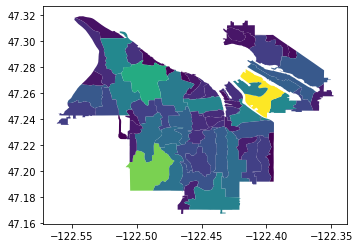

In [143]:
#Plot geodataframe
gdf.plot(column='Total Suspended Solids')